
### 1. Import the required libraries.

In [ ]:
# data processing and visualization
import numpy as np
import pandas as pd
import os, datetime
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler


# for building model
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers,models

import warnings
warnings.filterwarnings('ignore')

### 2. Give stock data using Yahoo Finance API.

Find the ticker symbol of any stock and load its data for around 10-15 years.

In [ ]:
# Define the ticker symbol
tickerSymbol = 'TATAMOTORS.NS'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
df = tickerData.history(period='1d', start='2005-12-15', end='2023-06-15')

In [ ]:
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2005-12-15 00:00:00+05:30,102.130409,103.040878,99.440370,101.178543,9739952,0.0,0.0
1,2005-12-16 00:00:00+05:30,101.195101,102.792570,99.763176,102.486320,12630002,0.0,0.0
2,2005-12-19 00:00:00+05:30,102.825685,103.760988,101.161999,103.156761,12547145,0.0,0.0
3,2005-12-20 00:00:00+05:30,103.131932,105.449498,102.651860,104.729401,12217855,0.0,0.0
4,2005-12-21 00:00:00+05:30,105.118436,105.838534,102.900184,103.876877,15857081,0.0,0.0


### 3. Select only the columns : Open, High, Low, Volume, Close.
At first, reset the indices of the data as they create problems while plotting.

The index of the "Close" column matters as it is our target variable.

Have a look at the data.

In [ ]:
cols = ['Open','High','Low','Volume','Close']
df=df[cols]
df.head()

,Open,High,Low,Volume,Close
0,102.130409,103.040878,99.440370,9739952,101.178543
1,101.195101,102.792570,99.763176,12630002,102.486320
2,102.825685,103.760988,101.161999,12547145,103.156761
3,103.131932,105.449498,102.651860,12217855,104.729401
4,105.118436,105.838534,102.900184,15857081,103.876877


### 4. On running the following cell , you can see the Close price of the stock and the Volume plotted against time.

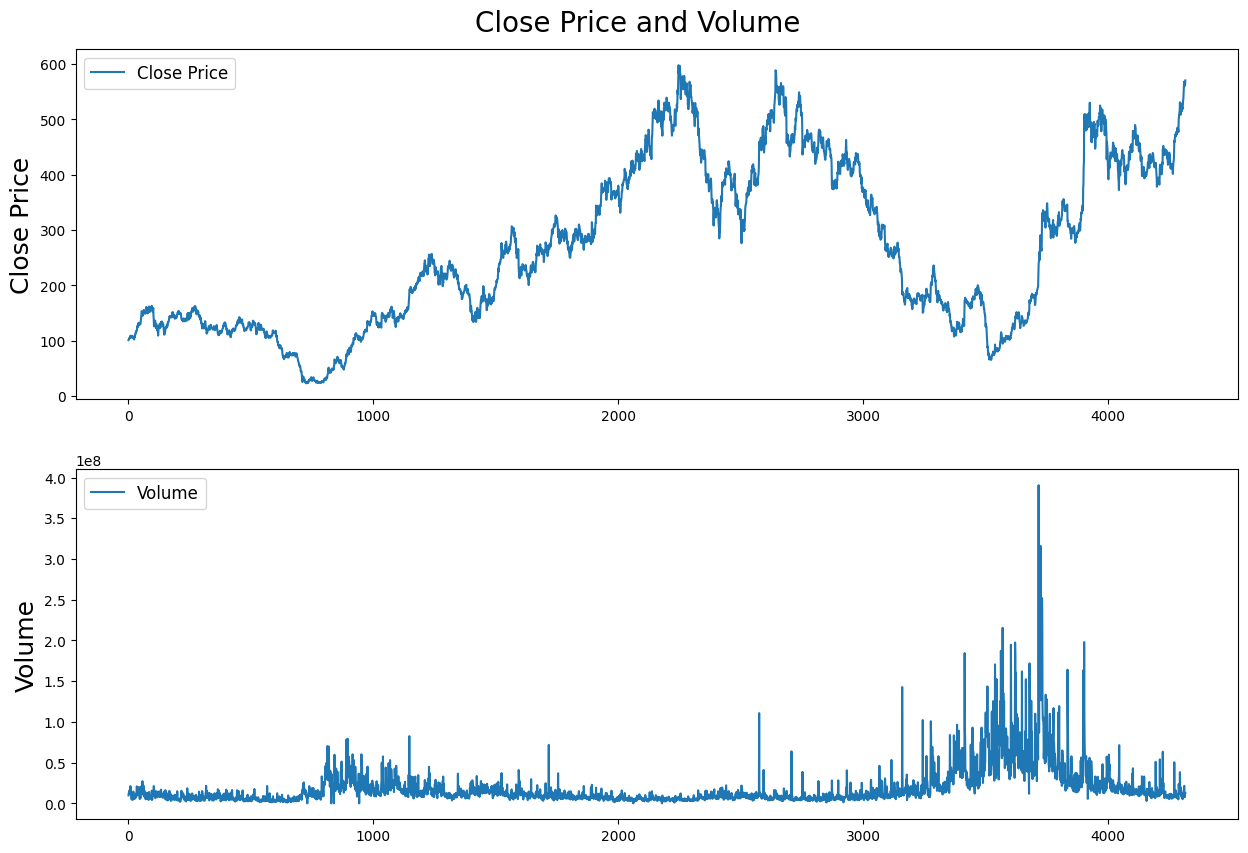

In [ ]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='Close Price')
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='Volume')
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

### 5. Use Min Max Scaler to scale the data in the range (0,1).

Remeber not to lose the dataframe. Instead store the scaled data in a new variable. You would need the stock data afterwards.

Have a look at the data. Also check its shape.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df)

In [ ]:
data[:10]

array([[0.13709804, 0.13583247, 0.13521347, 0.02493729, 0.13591007],
       [0.13547688, 0.13540555, 0.13578296, 0.03233671, 0.13818509],
       [0.13830316, 0.13707059, 0.13825073, 0.03212457, 0.1393514 ],
       [0.13883398, 0.13997372, 0.1408791 , 0.03128149, 0.14208719],
       [0.14227718, 0.1406426 , 0.14131718, 0.04059903, 0.14060412],
       [0.14026865, 0.1408276 , 0.14241234, 0.03152898, 0.14292233],
       [0.14341052, 0.14188068, 0.14352208, 0.0335726 , 0.14401662],
       [0.142851  , 0.14179529, 0.14147778, 0.03418681, 0.14336867],
       [0.14282234, 0.14808546, 0.14406238, 0.05411159, 0.14983378],
       [0.14973736, 0.14708926, 0.14629648, 0.037024  , 0.14476537]])

In [ ]:
data.shape

(4316, 5)

### 6. Creating sequences from the data.

We want to build a model that can take stock data of 10 days to predict the data for the 11th day. For that, we have to input sequences and corresponding targets from the data.

In [ ]:
sequence_length =10
input_sequences=[]
targets=[]
for i in range(len(data) - sequence_length):
    input_sequences.append(data[i:i+sequence_length])
    targets.append(data[i+sequence_length])

input_sequences = np.array(input_sequences)
targets = np.array(targets)

### 7. Split the data

Split the data into training and testing samples. Don't shuffle. Order matters !

In [ ]:
n = len(input_sequences)
train_x = input_sequences[0:int(n*0.90)]
train_y = targets[0:int(n*0.90)]

test_x = input_sequences[int(n*0.90):]
test_y = targets[int(n*0.90):]

### 8. Create a class Time2Vec for time2vec encoding of our input sequences.

The research paper of time2vec encoding is here :  https://arxiv.org/pdf/1907.05321v1.pdf

It has 2 weights and 2 bias matrices.
1. Z1 = Weights w1 * inputs + bias b1
2. Z2 = Weights w2 * Z1 + bias b2
3. output = concat (sin(Z2) , Z1)


This will change the shape of our input sequences from (10,5) to (10,5+x) where x = kernel_size , an input parameter for the class.

In [ ]:
class Time2Vec(keras.layers.Layer):
    def __init__(self, kernel_size):
        super().__init__(trainable=True, name='Time2Vec')
        self.k = kernel_size

    def build(self, input_shape):

        self.w = self.add_weight(name='w',shape=(input_shape[1], 1),initializer='uniform',trainable=True)

        self.p = self.add_weight(name='p',shape=(input_shape[1], 1),initializer='uniform',trainable=True)

        self.W = self.add_weight(name='W',shape=(input_shape[-1], self.k),initializer='uniform',trainable=True)

        self.P = self.add_weight(name='P',shape=(input_shape[1], self.k),initializer='uniform',trainable=True)


        super().build(input_shape)

    def call(self, inputs):
        # print(inputs.shape , self.w.shape, self.p.shape, self.W.shape, self.P.shape)

        original = self.w * inputs + self.p
        sin_trans = tf.math.sin(tf.tensordot(original, self.W , axes=1) + self.P)

        # print(original.shape , sin_trans.shape)

        # ans = tf.concat([sin_trans, original], -1)

        return sin_trans

### 9. Creating a transformer Encoder model.

1. Start by creating an encoder layer. It should take the following parameters while initialisation :
> a) Number of heads for the Multi Head Attention layer.<br/>
b) Embedding dimension : 5+x .<br/>
c) Dimensions of the feed forward layer.<br/>
d) Dropout rate.
>
Its architecture :

  1. Multi Head Attention
  2. Dropout layer for regularization.
  3. Addition and Layer Normalization.
  4. A Feed forward network which returns output of the same shape as embedding dimension.
  5. Dropout.
  6. Addition and Layer Normalization.


In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, num_heads=2, embed_dim=8, feed_forward_dim=16, rate=0.1):
        super().__init__()

        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([layers.Dense(feed_forward_dim, activation="relu"),
                                     layers.Dense(16,activation="relu"),
                                     layers.Dense(embed_dim),])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.attn(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

2. Then create the encoder model. It should take the following parameters while initialisation :
> a) Number of heads for the Multi Head Attention layer.<br/>
b) Time_steps : 10 . Stock data of 10 days as input. <br/>
c) Features : 5 . 5 features for each day price. <br/>
d) Kernel size for the time2vec encoding : x .<br/>
e) Dimensions of the feed forward layer inside the encoder layer.<br/>
f) Number of encoder layers to be stacked.
g) Dropout rate.
>
Its architecture :

  1. Optional Input Layer
  2. Time2Vec encoding
  3. Sequential Model for the stack of encoder layers.
  >
  This will output vectors of shape (10,5+x) but we need predictions of shape (1,5). So...
  4. Global Average Pooling Layer to make outputs of shape (1,5+x).
  5. Dropout.
  6. A Feed Forward Layer.
  7. Dropout
  8. Final Feed Forward Layer.

In [ ]:
class T2VTransformer(keras.Model):
    def __init__(self,num_hid=5,time_steps=10,num_head=2,kernel_size=3,num_feed_forward=16,num_layers_enc=3, rate=0.1):

        super().__init__()
        self.num_hid = num_hid
        self.numlayers_enc = num_layers_enc
        self.input_layer = layers.Input((time_steps, self.num_hid))
        self.time2vec = Time2Vec(kernel_size = kernel_size)
        self.enc_input = layers.Input((time_steps, self.num_hid + kernel_size))

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_heads=num_head,embed_dim= self.num_hid + kernel_size, feed_forward_dim=num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )
        self.GlobalAveragePooling1D = layers.GlobalAveragePooling1D(data_format='channels_last')
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.out1 = layers.Dense(units=64, activation='linear')
        self.out2 = layers.Dense(units=num_hid, activation='linear')

    def call(self, inputs):
        x1 = inputs
        x2 = self.time2vec(x1)
        x = tf.concat([x1,x2], axis=2)

        x = self.encoder(x)

        x = self.GlobalAveragePooling1D(x)
        x = self.dropout1(x)
        x = self.out1(x)
        x = self.dropout2(x)
        return self.out2(x)

### 10. Create an instance of the model.

Adam Optimizer and MSE loss function. Fit the model on the training data.

In [ ]:
model = T2VTransformer(num_hid=5,time_steps=10,num_head= 3,kernel_size=3,num_layers_enc=6,num_feed_forward=64)

opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(optimizer=opt, loss='mse')

In [ ]:
history = model.fit(train_x,train_y,epochs =10)

Epoch 1/10
122/122 [==============================] - 35s 64ms/step - loss: 0.1285
Epoch 2/10
122/122 [==============================] - 4s 35ms/step - loss: 0.0280
Epoch 3/10
122/122 [==============================] - 5s 44ms/step - loss: 0.0176
Epoch 4/10
122/122 [==============================] - 4s 34ms/step - loss: 0.0124
Epoch 5/10
122/122 [==============================] - 4s 32ms/step - loss: 0.0102
Epoch 6/10
122/122 [==============================] - 5s 42ms/step - loss: 0.0085
Epoch 7/10
122/122 [==============================] - 4s 33ms/step - loss: 0.0070
Epoch 8/10
122/122 [==============================] - 4s 32ms/step - loss: 0.0068
Epoch 9/10
122/122 [==============================] - 6s 47ms/step - loss: 0.0059
Epoch 10/10
122/122 [==============================] - 4s 32ms/step - loss: 0.0055


### 11. Testing

Evaluate the model performance on the test data.

Store the model predictions on the test data.

Inverse transform the predictions and the test targets to bring them to their original scale. Then calculate MSE.

Plot the predictions and the test targets.

Instead, you can predict on the entire data and plot the graph.

In [ ]:
model.evaluate(test_x,test_y)

14/14 [==============================] - 1s 12ms/step - loss: 0.0047


0.004704189021140337

In [ ]:
y_pred = model.predict(test_x)

14/14 [==============================] - 1s 11ms/step


In [ ]:
y_pred = scaler.inverse_transform(y_pred)
test_y = scaler.inverse_transform(test_y)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y[:,4], y_pred[:,4])

1865.914920472311

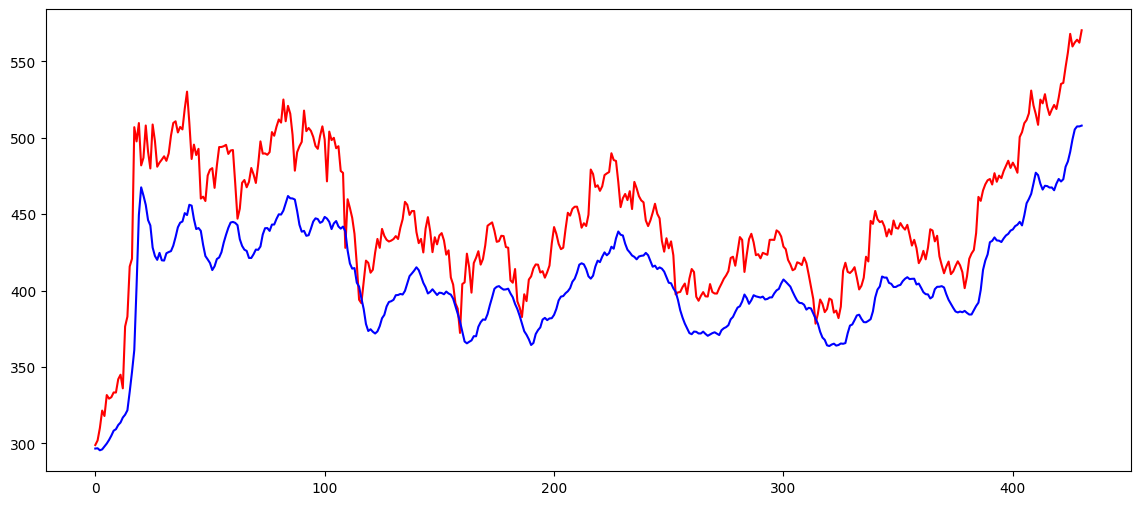

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(test_y[:,4], label='Close Price', color='red')
plt.plot(y_pred[:,4], label='Predicted Close Price', color='blue')
plt.legend()

## Limitations of the model

The model can be used to predict stock data for only the next day. You may consider taking that prediction and use it as input to predict data two days later. However, after some time, the model will only output a single value. It can't be operated for a long time prediction.

<b>How can we predict for more days in the future ?

</b> We have to train another model that will be trained on the specific number of days that has to be predicted.

Let's try out a 3-days model.

### What are the challenges ?

A feed forward network can't produce outputs of shape (m,n) . So, we will produce outputs of shape m*n and then reshape them. tf.reduce_prod() can be a lifesaver.

Pass num_days as an extra parameter to the model.

Split the data accordingly.

In [ ]:
num_days =3

In [ ]:
class T2VTransformer(keras.Model):
    def __init__(self,num_days,num_hid,time_steps,num_head,kernel_size,num_feed_forward,num_layers_enc, rate):

        super().__init__()
        self.num_days = num_days
        self.num_hid = num_hid
        self.numlayers_enc = num_layers_enc
        self.input_layer = layers.Input((time_steps, self.num_hid))
        self.time2vec = Time2Vec(kernel_size = kernel_size)
        self.enc_input = layers.Input((time_steps, self.num_hid + kernel_size))

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_heads=num_head,embed_dim= self.num_hid + kernel_size, feed_forward_dim=num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )
        self.GlobalAveragePooling1D = layers.GlobalAveragePooling1D(data_format='channels_last')
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.out1 = layers.Dense(units=64, activation='linear')
        self.out2 = layers.Dense(units=num_days*num_hid, activation='linear')

    def call(self, inputs):
        x1 = inputs
        x2 = self.time2vec(x1)
        x = tf.concat([x1,x2], axis=2)

        x = self.encoder(x)

        x = self.GlobalAveragePooling1D(x)
        x = self.dropout1(x)
        x = self.out1(x)
        x = self.dropout2(x)
        x = self.out2(x)

        shape = tf.shape(x)
        first_dim = tf.reduce_prod(shape) // (self.num_days*self.num_hid)
        x = tf.reshape(x,(first_dim,self.num_days,self.num_hid))
        return x

In [ ]:
model = T2VTransformer(num_days=num_days,num_hid=5,time_steps=10,num_head= 3,kernel_size=3,num_layers_enc=6,num_feed_forward=64, rate=0.1)

opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(optimizer=opt, loss='mse')

In [ ]:
sequence_length =10
input_sequences=[]
targets=[]
for i in range(len(data) - sequence_length - num_days):
    input_sequences.append(data[i:i+sequence_length])
    targets.append(data[i+sequence_length:i+sequence_length + num_days])

input_sequences = np.array(input_sequences)
targets = np.array(targets)

In [ ]:
n = len(input_sequences)
train_x = input_sequences[0:int(n*0.90)]
train_y = targets[0:int(n*0.90)]

test_x = input_sequences[int(n*0.90):]
test_y = targets[int(n*0.90):]

In [ ]:
history = model.fit(train_x,train_y,epochs =10)

Epoch 1/10
121/121 [==============================] - 24s 23ms/step - loss: 0.0611
Epoch 2/10
121/121 [==============================] - 3s 23ms/step - loss: 0.0097
Epoch 3/10
121/121 [==============================] - 3s 27ms/step - loss: 0.0069
Epoch 4/10
121/121 [==============================] - 3s 22ms/step - loss: 0.0056
Epoch 5/10
121/121 [==============================] - 3s 24ms/step - loss: 0.0046
Epoch 6/10
121/121 [==============================] - 3s 22ms/step - loss: 0.0046
Epoch 7/10
121/121 [==============================] - 3s 27ms/step - loss: 0.0040
Epoch 8/10
121/121 [==============================] - 3s 22ms/step - loss: 0.0038
Epoch 9/10
121/121 [==============================] - 3s 23ms/step - loss: 0.0036
Epoch 10/10
121/121 [==============================] - 3s 23ms/step - loss: 0.0033


In [ ]:
model.evaluate(test_x,test_y)

14/14 [==============================] - 1s 12ms/step - loss: 0.0016


0.0015634665032848716

In [ ]:
pred = model.predict(test_x)

14/14 [==============================] - 1s 11ms/step


In [ ]:
print(mean_squared_error(test_y[:,0,4],pred[:,0,4]))
print(mean_squared_error(test_y[:,1,4],pred[:,2,4]))
print(mean_squared_error(test_y[:,1,4],pred[:,2,4]))

0.001118602348193541
0.001505510197392953
0.001505510197392953


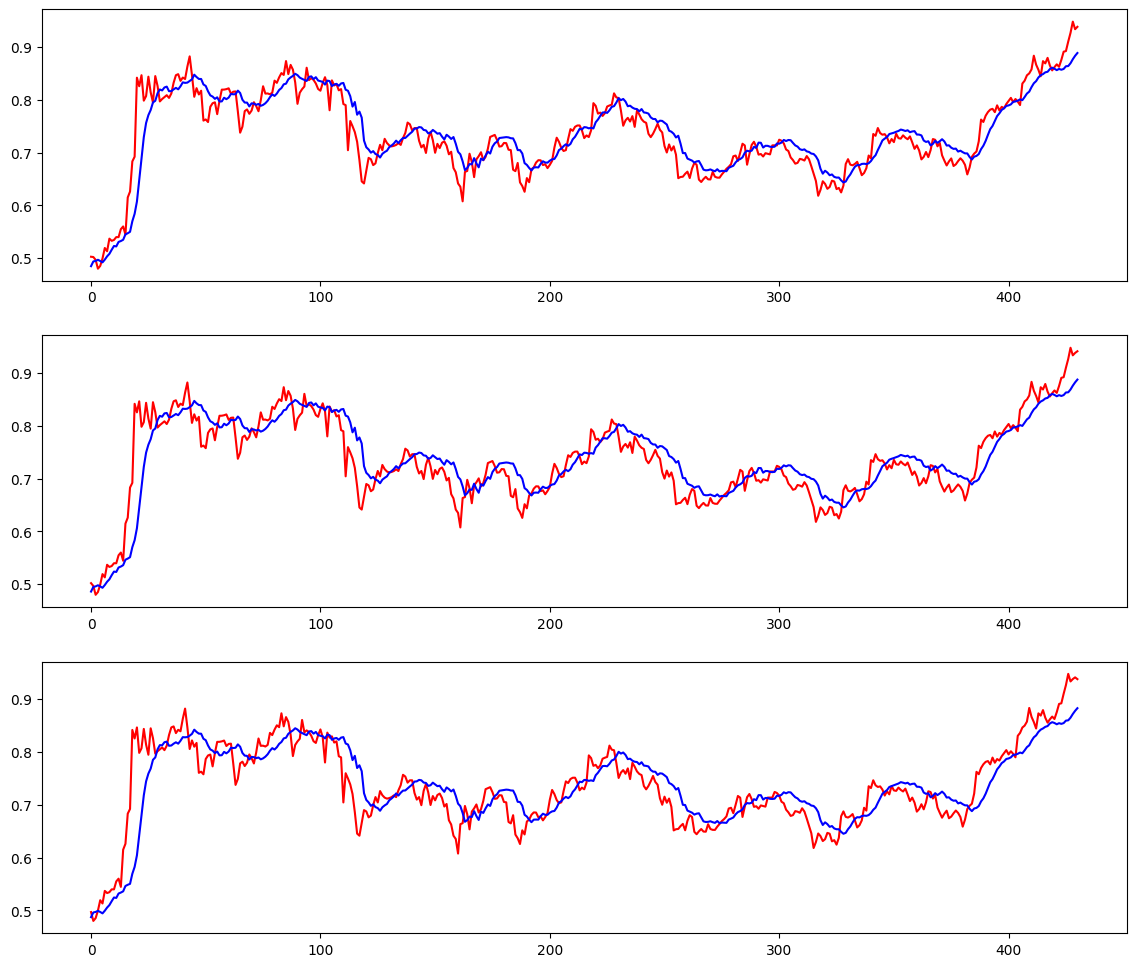

In [ ]:
plt.figure(figsize=(14,12))

plt.subplot(311)
plt.plot(test_y[:,0,4], label='Close Price', color='red')
plt.plot(pred[:,0,4], label='Predicted Close Price', color='blue')

plt.subplot(312)
plt.plot(test_y[:,1,4], label='Close Price', color='red')
plt.plot(pred[:,1,4], label='Predicted Close Price', color='blue')

plt.subplot(313)
plt.plot(test_y[:,2,4], label='Close Price', color='red')
plt.plot(pred[:,2,4], label='Predicted Close Price', color='blue')

## Improvements that has to be made

In the upcoming weeks, we have to automate the process of making models according to num-days. Moreover, we need to save the models so that they need not be trained again and again.